# Inverted representation
this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#choose the model
pret_mod = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 41.8MB/s]


In [2]:
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable

def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im

def recreate_image(im_as_var):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


In [3]:
from torch.optim import SGD
class InvertedRepresentation():
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def alpha_norm(self, input_matrix, alpha):
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm

    def total_variation_norm(self, input_matrix, beta):
        to_check = input_matrix[:, :-1, :-1]  # Trimmed: right - bottom
        one_bottom = input_matrix[:, 1:, :-1]  # Trimmed: top - right
        one_right = input_matrix[:, :-1, 1:]  # Trimmed: top - right
        total_variation = (((to_check - one_bottom)**2 +
                            (to_check - one_right)**2)**(beta/2)).sum()
        return total_variation

    def euclidian_loss(self, org_matrix, target_matrix):
        distance_matrix = target_matrix - org_matrix
        euclidian_distance = self.alpha_norm(distance_matrix, 2)
        normalized_euclidian_distance = euclidian_distance / self.alpha_norm(org_matrix, 2)
        return normalized_euclidian_distance

    def get_output_from_specific_layer(self, x, layer_id):
        layer_output = None
        for index, layer in enumerate(self.model.features):
            x = layer(x)
            if str(index) == str(layer_id):
                layer_output = x[0]
                break
        return layer_output

    def generate_inverted_image_specific_layer(self, input_image, img_size, target_layer=3):
        opt_img = Variable(1e-1 * torch.randn(1, 3, img_size, img_size), requires_grad=True)
        optimizer = SGD([opt_img], lr=1e4, momentum=0.9)
        input_image_layer_output = \
            self.get_output_from_specific_layer(input_image, target_layer)
        alpha_reg_alpha = 6
        alpha_reg_lambda = 1e-7
        tv_reg_beta = 2
        tv_reg_lambda = 1e-8
        images = list()

        for i in range(201):
            optimizer.zero_grad()
            output = self.get_output_from_specific_layer(opt_img, target_layer)
            euc_loss = 1e-1 * self.euclidian_loss(input_image_layer_output.detach(), output)
            reg_alpha = alpha_reg_lambda * self.alpha_norm(opt_img, alpha_reg_alpha)
            reg_total_variation = tv_reg_lambda * self.total_variation_norm(opt_img,
                                                                            tv_reg_beta)
            loss = euc_loss + reg_alpha + reg_total_variation
            loss.backward()
            optimizer.step()
            # Generate image every 25 iterations
            if i % 25 == 0:
                print('Iteration:', str(i), 'Loss:', loss.data.numpy())
                recreated_im = recreate_image(opt_img)
                im =save_image(recreated_im)
                images.append(im)

            if i % 40 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1/10
        return images

In [4]:


def inverted_representation_process(img, model, image_size,target_layer):
  '''
  inverted representation
  '''
  im, pred_cls = process_img(img, model)
  inverted_representation = InvertedRepresentation(model)
  images = inverted_representation.generate_inverted_image_specific_layer(im, image_size,target_layer)
  return images

def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
    plt.tight_layout()

In [5]:

target_layer = 0
image_size = 224

images = inverted_representation_process(img, pret_mod, image_size,target_layer)

Iteration: 0 Loss: 0.079090305
Iteration: 25 Loss: 0.019984987
Iteration: 50 Loss: 0.0127097545
Iteration: 75 Loss: 0.012160711
Iteration: 100 Loss: 0.012003107
Iteration: 125 Loss: 0.01196233
Iteration: 150 Loss: 0.011957609
Iteration: 175 Loss: 0.011955269
Iteration: 200 Loss: 0.011954797


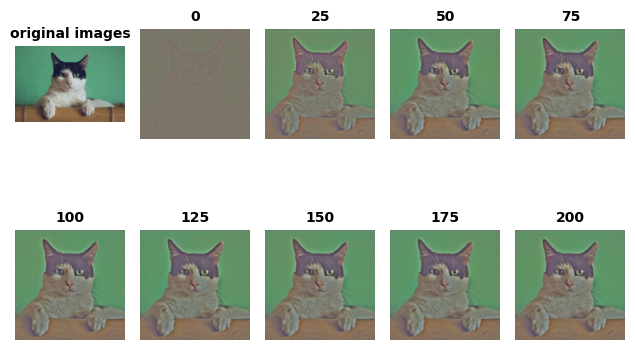

In [7]:
images = [img] +images
captions = ['original images'] + [str(i) for i in range(0,201,25)]
download_images(images, captions, cols = 5, rows = 2, size =10)

In [8]:
imgs = []
for i in range(0,12):
  print(i)
  images = inverted_representation_process(img, pret_mod, image_size,i)
  imgs.append(images[-1])

0
Iteration: 0 Loss: 0.07921104
Iteration: 25 Loss: 0.020003837
Iteration: 50 Loss: 0.012715791
Iteration: 75 Loss: 0.012165879
Iteration: 100 Loss: 0.012008016
Iteration: 125 Loss: 0.011967168
Iteration: 150 Loss: 0.011962438
Iteration: 175 Loss: 0.011960095
Iteration: 200 Loss: 0.0119596245
1
Iteration: 0 Loss: 0.08998845
Iteration: 25 Loss: 0.028219014
Iteration: 50 Loss: 0.014421579
Iteration: 75 Loss: 0.01332479
Iteration: 100 Loss: 0.0130323395
Iteration: 125 Loss: 0.012958627
Iteration: 150 Loss: 0.012950142
Iteration: 175 Loss: 0.0129459435
Iteration: 200 Loss: 0.012945099
2
Iteration: 0 Loss: 0.086262636
Iteration: 25 Loss: 0.023628566
Iteration: 50 Loss: 0.0156185515
Iteration: 75 Loss: 0.01475548
Iteration: 100 Loss: 0.014548276
Iteration: 125 Loss: 0.014495043
Iteration: 150 Loss: 0.014488833
Iteration: 175 Loss: 0.014485818
Iteration: 200 Loss: 0.014485213
3
Iteration: 0 Loss: 0.08843768
Iteration: 25 Loss: 0.012734764
Iteration: 50 Loss: 0.007335396
Iteration: 75 Loss: 0.

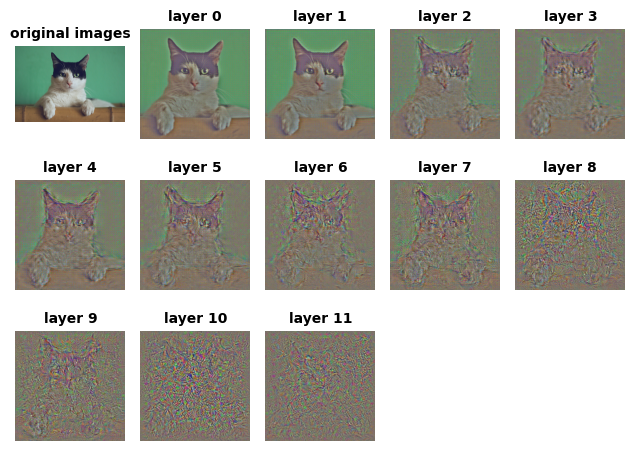

In [16]:
def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
      ax[-2].set_visible(False)
    plt.tight_layout()

images = [img] +imgs
captions = ['original images'] + ['layer '+ str(i) for i in range(0,12)]
download_images(images, captions, cols = 5, rows = 3, size =10)

In [10]:
len(imgs)

12